In [2]:
# Necessary
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchdiffeq import odeint_adjoint as odeint
# from jupyterthemes import jtplot
from utils import *
# jtplot.style(theme="chesterish")
 # CONSTANT 
device = "cpu"
EPOCHS=1
BATCH_SIZE=32
IMG_SIZE=(32,32,3)

In [3]:
# Load data
DIR = "./data/mnist/"
MNIST = torchvision.datasets.MNIST(DIR,
                                   train=True,
                                   transform=None,
                                   target_transform=None, download=False)


#ds_len_, normal_ds_, pertubed_ds_ = preprocess_data(MNIST)


/home/administrator/anaconda3/envs/neural_ode/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def train_model(model, optimizer, train_loader, val_loader,loss_fn, epochs=100):
    print(model.eval())
    print(f"Numbers of parameters in model: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
    for epoch_id in tqdm(range(epochs)):
        total = 0
        correct = 0
        running_loss = 0
        print(f"Start epoch number: {epoch_id + 1}")
        for batch_id, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            #print(f"Start batch number: {batch_id + 1} in epoch number: {epoch_id + 1}")
            inputs, labels = data
            #print(f"Get data done")
            # zero the parameter gradients
            optimizer.zero_grad()
            #print(f"Reset the optimizer backward, grad to 0") 
            # forward + backward + optimize
            outputs = model(inputs)
            #print(f"forward data through model")
            _, predicted = torch.max(outputs, 1)
            #print(f"Get predicted class")
            _, correct_labels = torch.max(labels, 1)
            #print(f"Get label class")
            #print(labels)
            total += labels.size(0)
            correct += correct += (predicted == correct_labels).sum().item()
            #print("Calculate the number of correct predictions")
            #print(labels.shape, outputs.shape)
            loss = loss_fn(outputs.float(), labels.float())
            loss.backward()
            #print("Backward loss")
            optimizer.step()
            #print("Step")
            running_loss += loss.item() 
            #print(f"End batch number: {batch_id + 1} in epoch number {epoch_id + 1}")
        acc = round(correct/total * 1.0, 2)
        #print("Accuracy was calculated")
        history["acc"].append(acc)
        history["loss"].append(running_loss)
        print("Before evaluate")
        val_loss, val_acc = model.evaluate(val_loader)
        print("After evaluation")
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch(s) {epoch_id + 1} | loss: {loss} | acc: {acc} | val_loss: {val_loss} | val_acc: {val_acc}")
    return history




def main(ds_len, ds, name = "mnist_50",batch_size=32,epochs=100, lr=1e-3,data_dis=[8000,2000,50000], device="cpu", result_dir="./result"):
    print(f"Number of train: {data_dis[0]}\nNumber of validation: {data_dis[1]}")
    train_set, val_set, _ = torch.utils.data.random_split(ds,data_dis)
    #print(type(train_set))
    assert isinstance(train_set,torch.utils.data.Dataset)
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_set, shuffle=True, batch_size=data_dis[1])
    loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
    ode_func = ODEBlock().to(device)
    ode_model = ODENet(ode_func, device=device).to(device)
    ode_optimizer = torch.optim.Adam(ode_model.parameters(), lr=lr)
    cnn_model = Network().to(device)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr)
    cnn_his = train_model(cnn_model, 
                         cnn_optimizer,
                         train_loader, val_loader, loss_fn=loss_fn,epochs=epochs)
    ode_his = train_model(ode_model,
                          ode_optimizer,
                          train_loader, val_loader, loss_fn=loss_fn, epochs=epochs)
    save_result(cnn_his,model_name="cnn",ds_name=name, result_dir=result_dir)
    save_result(ode_his,model_name="ode",ds_name=name, result_dir=result_dir)


AxesImage(54,36;334.8x217.44)


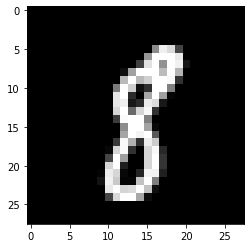

In [5]:
print(plt.imshow(np.array(MNIST[300][0]) / 255.0, cmap="gray"))

In [6]:
_ds_len, _ds = preprocess_data(MNIST)

In [10]:
print(_ds["50.0"][1].shape)

AttributeError: 'tuple' object has no attribute 'shape'